In [2]:
import pickle

train_data = pickle.load(open("../data/nfl-big-data-bowl-2024/play_by_play_train.pkl", "rb"))


In [54]:
val_data = pickle.load(open("../data/nfl-big-data-bowl-2024/play_by_play_val.pkl", "rb"))


In [11]:
import numpy as np

T = np.array([play["tackle_successful"] for play in train_data])
Y = np.array([play["yards_after_contact"] for play in train_data])
Y[T == 0].mean(), Y[T==1].mean()


(8.091281385281386, 2.5722669983416253)

Text(0.5, 0, 'Yards after contact')

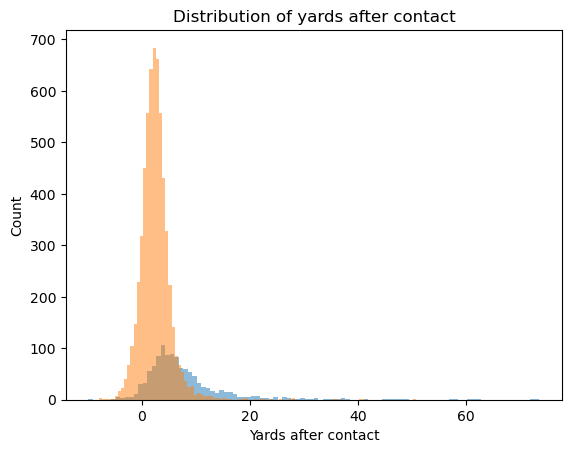

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.set_title("Distribution of yards after contact")
ax.hist(Y[T  == 0], alpha=0.5, bins=100)
ax.hist(Y[T == 1], alpha=0.5, bins=100)
ax.set_ylabel("Count")
ax.set_xlabel("Yards after contact")


In [13]:
model_name = "12layer_sgd1e-6_wd1e-4_explr0.8"
model_results = pickle.load(open(f"../lightning_logs/dragonnet_baseline/{model_name}/results.pkl", "rb"))
model_results.keys()


dict_keys(['t_true', 'y_true', 'y0_pred', 'y1_pred', 't_pred', 'eps', 'cate', 't_loss', 'y0_loss', 'y1_loss', 'y_loss', 'loss_total', 'loss_total_tarreg', 'tarreg', 't_auroc', 'factual_y0_mae', 'factual_y0_mse', 'factual_y0_r2', 'factual_y1_mae', 'factual_y1_mse', 'factual_y1_r2', 'factual_mae', 'factual_mse', 'factual_r2', 'zero_baseline_mae', 'zero_baseline_mse', 'zero_baseline_r2', 'const_baseline_mae', 'const_baseline_mse', 'const_baseline_r2'])

(array([  2.,   1.,   0.,   6.,  24.,  35.,  24.,   7.,  11.,  30., 144.,
        518., 338.,  58.,  11., 106., 377.,  24.,   0.]),
 array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 <BarContainer object of 19 artists>)

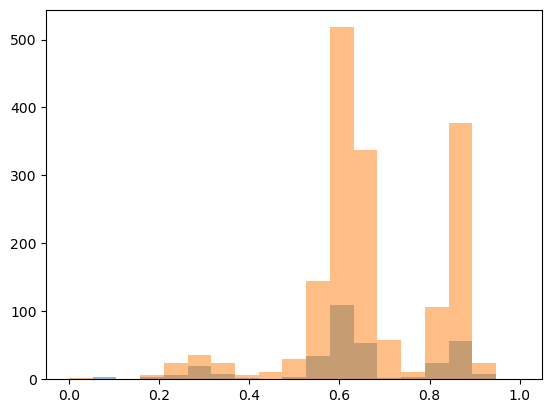

In [20]:
val_T = model_results["t_true"]
val_Y = model_results["y_true"]
val_T_pred = model_results["t_pred"]

fig, ax = plt.subplots()
ax.hist(val_T_pred[val_T == 0], alpha=0.5, bins=np.linspace(0, 1, 20))
ax.hist(val_T_pred[val_T == 1], alpha=0.5, bins=np.linspace(0, 1, 20))


(array([ 19.,   8.,  12.,   5.,  64., 713., 777., 376.,  66.,  13.]),
 array([-9.75265598, -8.78260231, -7.81254864, -6.84249496, -5.87244081,
        -4.90238714, -3.93233347, -2.9622798 , -1.992226  , -1.02217233,
        -0.05211854]),
 <BarContainer object of 10 artists>)

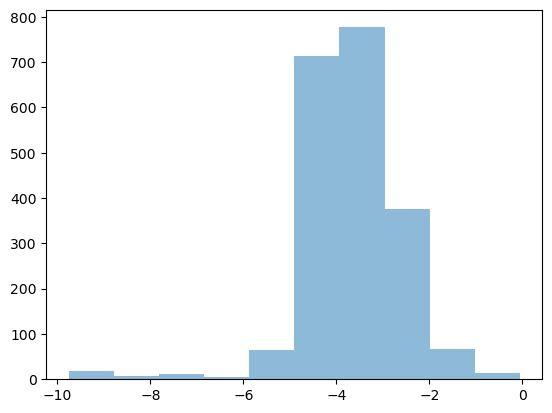

In [22]:
fig, ax = plt.subplots()
ax.hist(model_results['cate'], alpha=0.5)


Text(0, 0.5, 'Count')

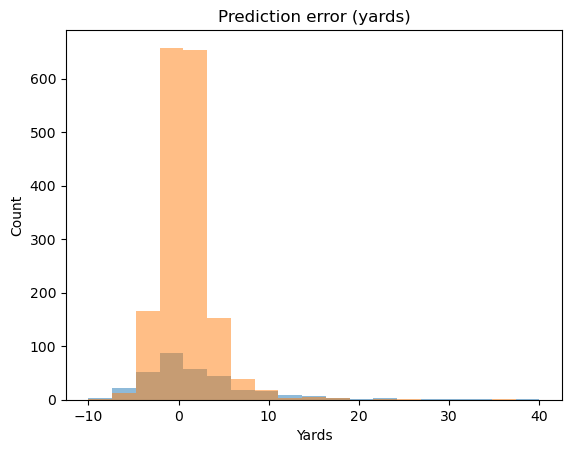

In [29]:
import torch

y0_pred = model_results['y0_pred']
y1_pred = model_results['y1_pred']
y_true = model_results['y_true']

fig, ax = plt.subplots()
ax.set_title("Prediction error (yards)")
ax.hist(y_true[val_T == 0] - y0_pred[val_T == 0], alpha=0.5, bins=np.linspace(-10, 40, 20))
ax.hist(y_true[val_T == 1] - y1_pred[val_T == 1], alpha=0.5, bins=np.linspace(-10, 40, 20))
ax.set_xlabel("Yards")
ax.set_ylabel("Count")


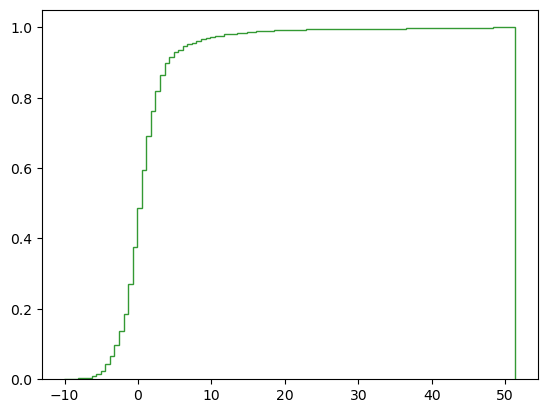

In [41]:
factual_err = torch.where(val_T == 1, y_true - y1_pred, y_true - y0_pred )
fig, ax = plt.subplots()
_ = ax.hist(factual_err, density=True, cumulative=True, label='CDF',
         histtype='step', alpha=0.8, color="green", bins=np.linspace(-10.03, 51.38, 100))


In [248]:
quantiles = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99, 1.]
results = np.abs(factual_err)[val_Y < 10]
print("N:", len(results))
quants = np.quantile(results, quantiles)

for quant, quantile in zip(quants, quantiles):
    print(f"{quantile:.0%} error percentile: {quant:.2f} yds",)


N: 1924
0% error percentile: 0.00 yds
1% error percentile: 0.03 yds
2% error percentile: 0.06 yds
3% error percentile: 0.08 yds
4% error percentile: 0.11 yds
5% error percentile: 0.14 yds
10% error percentile: 0.27 yds
20% error percentile: 0.52 yds
30% error percentile: 0.83 yds
40% error percentile: 1.12 yds
50% error percentile: 1.43 yds
60% error percentile: 1.83 yds
70% error percentile: 2.40 yds
80% error percentile: 3.06 yds
90% error percentile: 3.92 yds
95% error percentile: 4.85 yds
96% error percentile: 5.15 yds
97% error percentile: 5.67 yds
98% error percentile: 6.13 yds
99% error percentile: 6.67 yds
100% error percentile: 10.02 yds


In [276]:
# adapted from https://www.kaggle.com/code/huntingdata11/animated-and-interactive-nfl-plays-in-plotly
colors = {
    'ARI':"#97233F", 
    'ATL':"#A71930", 
    'BAL':'#241773', 
    'BUF':"#00338D", 
    'CAR':"#0085CA", 
    'CHI':"#C83803", 
    'CIN':"#FB4F14", 
    'CLE':"#311D00", 
    'DAL':'#003594',
    'DEN':"#FB4F14", 
    'DET':"#0076B6", 
    'GB':"#203731", 
    'HOU':"#03202F", 
    'IND':"#002C5F", 
    'JAX':"#9F792C", 
    'KC':"#E31837", 
    'LA':"#003594", 
    'LAC':"#0080C6", 
    'LV':"#000000",
    'MIA':"#008E97", 
    'MIN':"#4F2683", 
    'NE':"#002244", 
    'NO':"#D3BC8D", 
    'NYG':"#0B2265", 
    'NYJ':"#125740", 
    'PHI':"#004C54", 
    'PIT':"#FFB612", 
    'SEA':"#69BE28", 
    'SF':"#AA0000",
    'TB':'#D50A0A', 
    'TEN':"#4B92DB", 
    'WAS':"#5A1414", 
    'football':'#825736'
}

UPDATE_MENUS = [
        {
            "buttons": [
                {
                    "args": [None, {"frame": {"duration": 100, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 0}}],
                    "label": "Play",
                    "method": "animate"
                },
                {
                    "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}],
                    "label": "Pause",
                    "method": "animate"
                }
            ],
            "direction": "left",
            "pad": {"r": 10, "t": 87},
            "showactive": False,
            "type": "buttons",
            "x": 0.1,
            "xanchor": "right",
            "y": 0,
            "yanchor": "top"
        }
    ]

def get_initial_slider_dict():
    return {
        "active": 0,
        "yanchor": "top",
        "xanchor": "left",
        "currentvalue": {
            "font": {"size": 20},
            "prefix": "Frame:",
            "visible": True,
            "xanchor": "right"
        },
        "transition": {"duration": 300, "easing": "cubic-in-out"},
        "pad": {"b": 10, "t": 50},
        "len": 0.9,
        "x": 0.1,
        "y": 0,
        "steps": []
    }

def draw_numbers(y):
    return go.Scatter(
                x=np.arange(20,110,10), 
                y=[y]*len(np.arange(20,110,10)),
                mode='text',
                text=list(map(str,list(np.arange(20, 61, 10)-10)+list(np.arange(40, 9, -10)))),
                textfont_size = 30,
                textfont_family = "Courier New, monospace",
                textfont_color = "#ffffff",
                showlegend=False,
                hoverinfo='none'
            )

def draw_vert(x, color, line_dash='dash', text=None, opacity=1.):
    return go.Scatter(
                x=[x,x], 
                y=[0,53.5],
                mode="lines+text",
                line_dash=line_dash,
                line_color=color,
                showlegend=False,
                opacity=opacity,
                hovertext=text,
                hoverinfo="text",
            )

def get_slider_step(frameId):
    return {"args": [
            [frameId],
            {"frame": {"duration": 100, "redraw": False},
             "mode": "immediate",
             "transition": {"duration": 0}}
        ],
            "label": str(frameId),
            "method": "animate"
        }

FIELD_COLOR = "#3b8242"

def get_layout(gameId, playId, gameClock, quarter, playDescription, slider_dict, y0, y1, t, y, scale=10):
    factual_error = y - y0 if t == 0 else y - y1

    return go.Layout(
        autosize=False,
        width=120*scale,
        height=60*scale,
        xaxis=dict(range=[0, 120], autorange=False, tickmode='array',tickvals=np.arange(10, 111, 5).tolist(),showticklabels=False),
        yaxis=dict(range=[0, 53.3], autorange=False,showgrid=False,showticklabels=False),
        plot_bgcolor=FIELD_COLOR,
        # Create title and add play description at the bottom of the chart for better visual appeal
        title = f"GameId: {gameId}, PlayId: {playId} ({gameClock} {quarter}Q)<br>" + \
            "<br>"*19 + \
            f"{playDescription}<br>" + \
            f"<b>Yards prevented/preventable: {y0-y1:.1f}yds</b> (+tackle: {y1:.1f}yds, -tackle: {y0:.1f}yds, actual: {y:.1f}yds, err:{factual_error:.1f}yds)<br>",
        updatemenus=UPDATE_MENUS,
        sliders = [slider_dict]
    )


def add_first_down_markers(fig, first_down_marker, down):
    for y_val in [0,53]:
        fig.add_annotation(
                x=first_down_marker,
                y=y_val,
                text=str(down),
                showarrow=False,
                font=dict(family="Courier New, monospace", size=16, color="black"),
                align="center",
                bordercolor="black",
                borderwidth=2,
                borderpad=4,
                bgcolor="#ff7f0e",
                opacity=1
                )

def draw_events(event_buffer):
    return go.Scatter(
        x=event_buffer["x"], y=event_buffer["y"],
        mode="markers+text",
        textposition="top left", textfont=dict(family="Courier New, monospace", size=14, color="white"), text=event_buffer["event"], marker_symbol="x",
        marker_color="white", hoverinfo="none"
    )

def draw_line_trace(buffer, color='white'):
    return go.Scatter(x=buffer["x"], y=buffer["y"],
        mode = 'lines', line = dict(color=color, dash='dot'),
        hoverinfo='none'
    )
    
def animate_play(tracking_df, play_df,players,gameId,playId,y0,y1,t,y):
    selected_play_df = play_df[(play_df.playId==playId)&(play_df.gameId==gameId)]
    
    tracking_players_df = pd.merge(tracking_df[(tracking_df.playId==playId) & (tracking_df.gameId==gameId)],players, how="left", on="nflId")
    selected_tracking_df = tracking_players_df[(tracking_players_df.playId==playId) & (tracking_players_df.gameId==gameId)]

    sorted_frame_list = selected_tracking_df.frameId.unique()
    sorted_frame_list.sort()
    play_direction_sign = (2 * (selected_tracking_df.iloc[0].playDirection == "right") - 1)
    # get play General information 
    line_of_scrimmage = selected_play_df.absoluteYardlineNumber.values[0]
    first_down_marker = line_of_scrimmage + selected_play_df.yardsToGo.values[0] * play_direction_sign
    down = selected_play_df.down.values[0]
    quarter = selected_play_df.quarter.values[0]
    gameClock = selected_play_df.gameClock.values[0]
    playDescription = selected_play_df.playDescription.values[0]
    # Handle case where we have a really long Play Description and want to split it into two lines
    if len(playDescription.split(" "))>15 and len(playDescription)>115:
        playDescription = " ".join(playDescription.split(" ")[0:16]) + "<br>" + " ".join(playDescription.split(" ")[16:])

    frames = []
    event_buffer = {"x": [], "y": [], "event": []}
    football_buffer = {"x": [], "y": []}
    slider_dict = get_initial_slider_dict()
    seen_first_contact = False
    first_contact_x = 0.
    for frameId in sorted_frame_list:
        data = []
        data.append(draw_numbers(5))
        data.append(draw_numbers(53.5-5))
        data.append(draw_vert(line_of_scrimmage, 'blue'))
        data.append(draw_vert(first_down_marker, 'yellow'))

        # Plot Players
        for club in selected_tracking_df.club.unique():
            plot_df = selected_tracking_df[(selected_tracking_df.club == club) & (selected_tracking_df.frameId == frameId)]
            if club != "football":
                hover_text_array = []
                for nflId in plot_df.nflId:
                    selected_player_df = plot_df[plot_df.nflId==nflId]
                    hover_str = ""
                    if nflId == selected_play_df.ballCarrierId.item():
                        hover_str += "BALL CARRIER<br>"
                    hover_str += f"{selected_player_df['displayName'].values[0]} ({ selected_player_df['position'].values[0]})"
                    hover_text_array.append(hover_str)
                data.append(go.Scatter(
                    x=plot_df["x"], y=plot_df["y"],
                    mode = 'markers',marker_color=colors[club],marker_symbol="circle" if club == selected_play_df.possessionTeam.values[0] else  "square",
                    name=club,hovertext=hover_text_array,hoverinfo="text"))
            else:
                event = plot_df.event.item()
                if frameId % 3 == 0:
                    football_buffer["x"].append(plot_df["x"].item())
                    football_buffer["y"].append(plot_df["y"].item())
                if not pd.isnull(event): 
                    if event == "first_contact":
                        seen_first_contact = True
                        first_contact_x = plot_df["x"].item()
                    event_buffer["x"].append(plot_df["x"].item())
                    event_buffer["y"].append(plot_df["y"].item())
                    event_buffer["event"].append(event)
                if seen_first_contact:
                    data.append(draw_vert(first_contact_x + y0 * play_direction_sign, "#00ff00", line_dash="dot", text="predicted LoS w/o tackle"))
                    data.append(draw_vert(first_contact_x + y1 * play_direction_sign, "red", line_dash="dot", text="predicted LoS w/ tackle"))
                else:
                    data.append(draw_vert(first_contact_x, "red", opacity=0))
                    data.append(draw_vert(first_contact_x, "red", opacity=0))

                data.append(draw_events(event_buffer))
                data.append(draw_line_trace(football_buffer))
                data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[club],name=club,hoverinfo='none',marker_symbol="diamond-wide"))
                
        # add frame to slider
        slider_step = get_slider_step(frameId) 
        slider_dict["steps"].append(slider_step)
        frames.append(go.Frame(data=data, name=str(frameId)))

    layout = get_layout(gameId, playId, gameClock, quarter, playDescription, slider_dict, y0, y1, t, y, scale=10)

    fig = go.Figure(data=frames[0]["data"], layout= layout, frames=frames[1:])
    # Create First Down Markers 
    add_first_down_markers(fig, first_down_marker, down)



    return fig


In [221]:
plays.head()


,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN
3,2022100212,2007,46461,Mike Boone,(13:12) M.Boone left tackle to DEN 44 for 7 ya...,3,2,10,DEN,LV,...,0.620552,0.379448,-0.002451,0.002451,1.641006,-0.043580,NaN,NaN,NaN,NaN
4,2022091900,1372,47857,Devin Singletary,(8:33) D.Singletary right guard to TEN 32 for ...,2,1,10,BUF,TEN,...,0.836290,0.163710,0.001053,-0.001053,3.686428,-0.167903,NaN,NaN,NaN,NaN


In [51]:
import os

import plotly.graph_objects as go
import pandas as pd

games = pd.read_csv("../data/nfl-big-data-bowl-2024/games.csv")
plays = pd.read_csv("../data/nfl-big-data-bowl-2024/plays.csv")
players = pd.read_csv("../data/nfl-big-data-bowl-2024/players.csv").drop("displayName",axis=1)
tracking_data = pd.concat([pd.read_csv(os.path.join(f"../data/nfl-big-data-bowl-2024/tracking_week_{i}.csv")) for i in range(1, 10)], axis=0)
tackles = pd.read_csv("../data/nfl-big-data-bowl-2024/tackles.csv")


In [105]:
tracking_data.columns


Index(['gameId', 'playId', 'nflId', 'displayName', 'frameId', 'time',
       'jerseyNumber', 'club', 'playDirection', 'x', 'y', 's', 'a', 'dis', 'o',
       'dir', 'event'],
      dtype='object')

In [142]:
y0_pred[:10]


tensor([7.3260, 5.2401, 5.7109, 5.9237, 4.8403, 6.5113, 6.2532, 4.3283, 5.7476,
        5.9832])

In [235]:
factual_err[1011]


tensor(-10.0204)

In [268]:
torch.argsort(torch.abs(factual_err))[900:1000]


tensor([1077, 1868,  424,  652, 2016, 1271,  369,   46,  239,  614,  746,  964,
        1102, 1937,  467,  483, 1471,  744, 1502, 1701,  566, 1552,  877,  261,
        1142,  560, 1650,  128, 1296,  853, 1852,  393,  949,  911, 2007,  791,
         440, 1658,  508, 1813, 1189, 1643,  976,  875, 2000, 1685, 1465, 1282,
         386, 1014,  696,  164, 2004,  539, 1037,  891,  277, 1889,  738,  961,
         388, 1405, 1906, 2025, 1521,   49,  841,  531,  252,  978, 1316,  490,
        1196, 1988, 1846,  141,  714,  790,  449, 1144,  760, 2037, 1280,  153,
         308, 1501, 1536, 1611, 1659, 2013, 1182,  820,  343,  232, 1819, 1978,
         910,   84, 1788, 1623])

In [278]:
INDEX = 560
animate_play(tracking_data, plays, players, val_data[INDEX]["game_id"], val_data[INDEX]["play_id"], y0_pred[INDEX], y1_pred[INDEX], val_T[INDEX], val_Y[INDEX])  # runtime for one play is <5s


In [117]:
%debug


> c:\users\trent\.conda\envs\nfl_bdb\lib\site-packages\pandas\core\generic.py(1519)__nonzero__()
   1517     @final
   1518     def __nonzero__(self) -> NoReturn:
-> 1519         raise ValueError(
   1520             f"The truth value of a {type(self).__name__} is ambiguous. "
   1521             "Use a.empty, a.bool(), a.item(), a.any() or a.all()."

> c:\users\trent\appdata\local\temp\ipykernel_35956\4249003201.py(198)animate_play()

Series([], Name: event, dtype: object)
> c:\users\trent\appdata\local\temp\ipykernel_35956\320005782.py(2)<module>()

> c:\users\trent\appdata\local\temp\ipykernel_35956\4249003201.py(198)animate_play()

    193                     hover_text_array.append(hover_str)
    194                 data.append(go.Scatter(x=plot_df["x"], y=plot_df["y"],mode = 'markers',marker_color=colors[club],name=club,hovertext=hover_text_array,hoverinfo="text"))
    195             else:
    196                 event = plot_df[plot_df.nflId == selected_play_df.ballCarrierId.it